In [163]:
from matplotlib import pyplot as plt
import numpy as np
import functions as func
import models as mod
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
import data_functions as df
import functions as f
from scipy.stats import ortho_group
import random

In [164]:
def train_simple(model, optimizer, loss_fn, train_x, train_y, num_epochs, train_size, batch_size):
    # Run SGD with fixed stepsize for specified number of epochs
    for epoch in tqdm(range(num_epochs+1)):
        # Compute generalization error at specified intervals
        hidden_weights = model.fc1.weight
        outer_weights = model.fc2.weight
        optimizer.zero_grad()
        # Randomly choose a data batch_size number of data points
        inds = random.sample(range(train_size), batch_size)
        batch_x = train_x[inds,:]
        batch_y = train_y[inds]
        batch_output = model(batch_x)
        loss = loss_fn(batch_output, batch_y, hidden_weights, outer_weights)
        loss.backward()
        optimizer.step()
    return model

In [462]:
def generate_subspace_data(V, n, d, r, num_corrupted, ns):
    n2 = int(np.floor(n / 2))
    y = torch.cat((-torch.ones(n2), torch.ones(n2)), 0)
    Y = torch.diag(y)
    Z = torch.cat((torch.rand(r,n)+0.5, ns*(torch.rand(d-r, n)-0.5)),0)
    X = V@Z@Y
    k = int(num_corrupted/2)
    y[:k] *= -1
    y[-k:] *= -1
    X = torch.transpose(X, 0, 1)
    y = torch.reshape(y, (n, 1))
    return X,y

In [3]:
# d= 2000
# r = 5
# b = 0.05
# noise_scale = 1.2
# n = 500
# num_corrupted = int(n*b)

# # !!!----- Student and teacher network choices -----!!!
# m = 30       # number of student neurons e.g., [50,200,500]
# bias_status = True # Note we only ever have a bias for the hidden layer
# # hidden_train_list = [True, False] # For some experiments we might want to only train the outer layer

# # !!!----- Optimizater choices -----!!!
# num_epochs = 5000          # Number of epochs
# plot_incs = np.concatenate((np.arange(0, 10, 1), np.arange(10, 100, 10), np.arange(100, num_epochs + 1, 100))) # Points at which compute test error etc.
# step_size = 0.5
# batch_size = 1

# # !!!----- Outcome thresholds -----!!!
# # Factors for classify different tests into categories of benign vs. non-benign overfit, fit or underfit.
# benign_ub = 1.2
# overfit_ub = 0.7
# fit_ub = 1.2

### Generate data

In [431]:
d= 500
r = 5
b = 0.1 #0.01
noise_scale = 2.0 #0.01
n = 200
num_corrupted = int(n*b)

In [432]:
# d= 500
# r = 5
# b = 0.1 #0.01
# noise_scale = 2 #0.01
# n = 200
# num_corrupted = int(n*b)

In [463]:
V = ortho_group.rvs(d)
V = torch.Tensor(V)
train_x, train_y = generate_subspace_data(V, n, d, r, num_corrupted, noise_scale)
test_x, test_y = generate_subspace_data(V, n, d, r, num_corrupted, noise_scale)
loss_fn = mod.loss_regularized("hinge", "none", 0, "none", 0)

<StemContainer object of 3 artists>

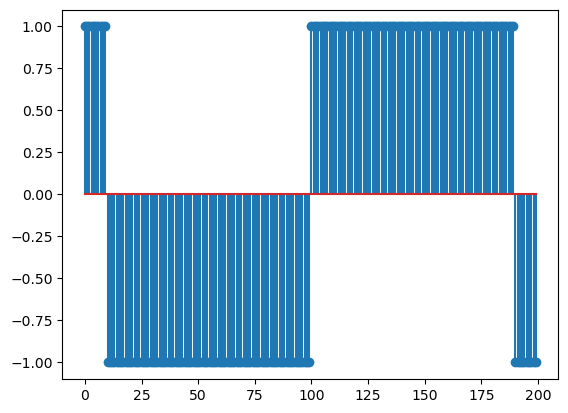

In [464]:
# Check the labels are created correctly
plt.stem(range(n),train_y)

<AxesSubplot:>

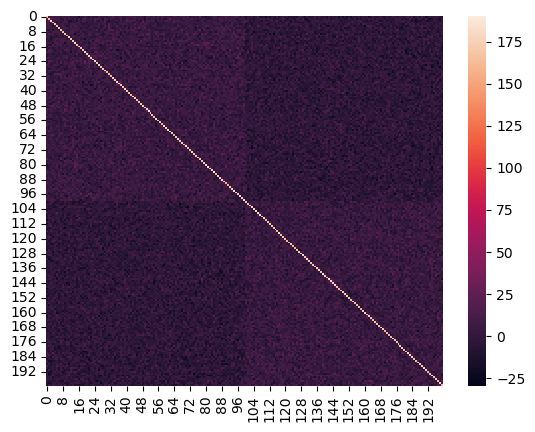

In [465]:
# Observe that there is no correlation structure in correlation matrix of inputs
# Visualize gram of the training data
Xt = train_x.detach().numpy()
G = Xt@Xt.transpose()
sns.heatmap(G)

Above matrix is clearly not orthogonal, and furthermore there is no class structure appearing. Note that first half are negative examples, and second half are positive examples. Furthermore, the first five and last five are false negative and false positive respectively. 

## Train model

In [449]:
# !!!----- Student and teacher network choices -----!!!
m = 100  # 16     # number of student neurons e.g., [50,200,500]
bias_status = False # Note we only ever have a bias for the hidden layer
train_outer = False
# hidden_train_list = [True, False] # For some experiments we might want to only train the outer layer

# !!!----- Optimizater choices -----!!!
num_epochs = 15000         # Number of epochs
plot_incs = np.concatenate((np.arange(0, 10, 1), np.arange(10, 100, 10), np.arange(100, num_epochs + 1, 100))) # Points at which compute test error etc.
step_size = 0.5 #0.5 #0.1
batch_size = 1

# !!!----- Outcome thresholds -----!!!
# Factors for classify different tests into categories of benign vs. non-benign overfit, fit or underfit.
benign_ub = 1.2
overfit_ub = 0.7
fit_ub = 1.2

In [450]:
model = mod.TwoLayerNN(d, m, bias_status=bias_status, train_outer=train_outer, act='ReLU')
optimizer = torch.optim.SGD(model.parameters(), step_size)

In [451]:
model = train_simple(model, optimizer, loss_fn, train_x, train_y, num_epochs, n, batch_size)

100%|███████████████████████████████████| 15001/15001 [00:05<00:00, 2972.44it/s]


In [452]:
final_test_error = (100/n)*torch.sum(torch.abs(0.5 * (torch.sign(model(test_x)) - test_y))).item()
final_train_error = (100/n)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x)) - train_y))).item()
print("Final train error: " + str(final_train_error))
print("Final test error: " + str(final_test_error))

Final train error: 0.5
Final test error: 11.0


### Extract model parameters for analysis

In [453]:
W = model.fc1.weight
# b = model.fc1.bias
# b = b.detach().numpy()

### Analysis of preactivations by neuron

In [454]:
C2 = W@torch.transpose(train_x, 0, 1)
C2 = C2.detach().numpy()

Text(0.5, 0.98, 'Preactivations of trained neurons against each data point')

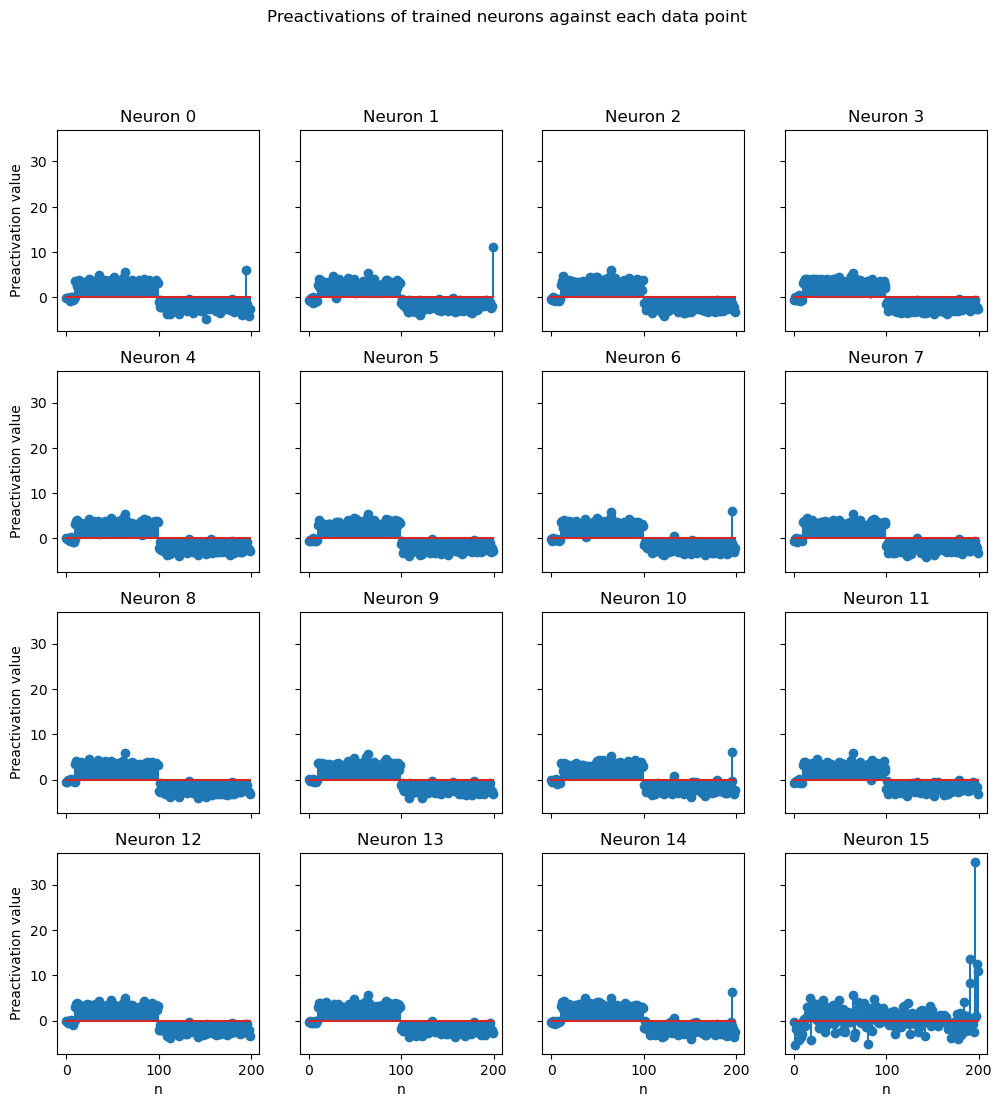

In [455]:
fig, axs = plt.subplots(4,4, figsize = (12,12), sharey = True, sharex = True)
for i in range(16):
    r = i//4
    c = i%4
    axs[r,c].stem(range(n), C2[i,:])
    axs[r,c].set_title("Neuron " + str(i))
    if (r == 3):
        axs[r,c].set_xlabel("n")
    if (c == 0):
        axs[r,c].set_ylabel("Preactivation value")
#     axs[r,c].axhline(y = b[i], color = 'k', linestyle = '-')
fig.suptitle("Preactivations of trained neurons against each data point")

### Analysis of inner products of each neuron with basis V

In [456]:
D = W@V
D = D.detach().numpy()

Text(0.5, 0.98, 'Inner product of neurons with columns of V')

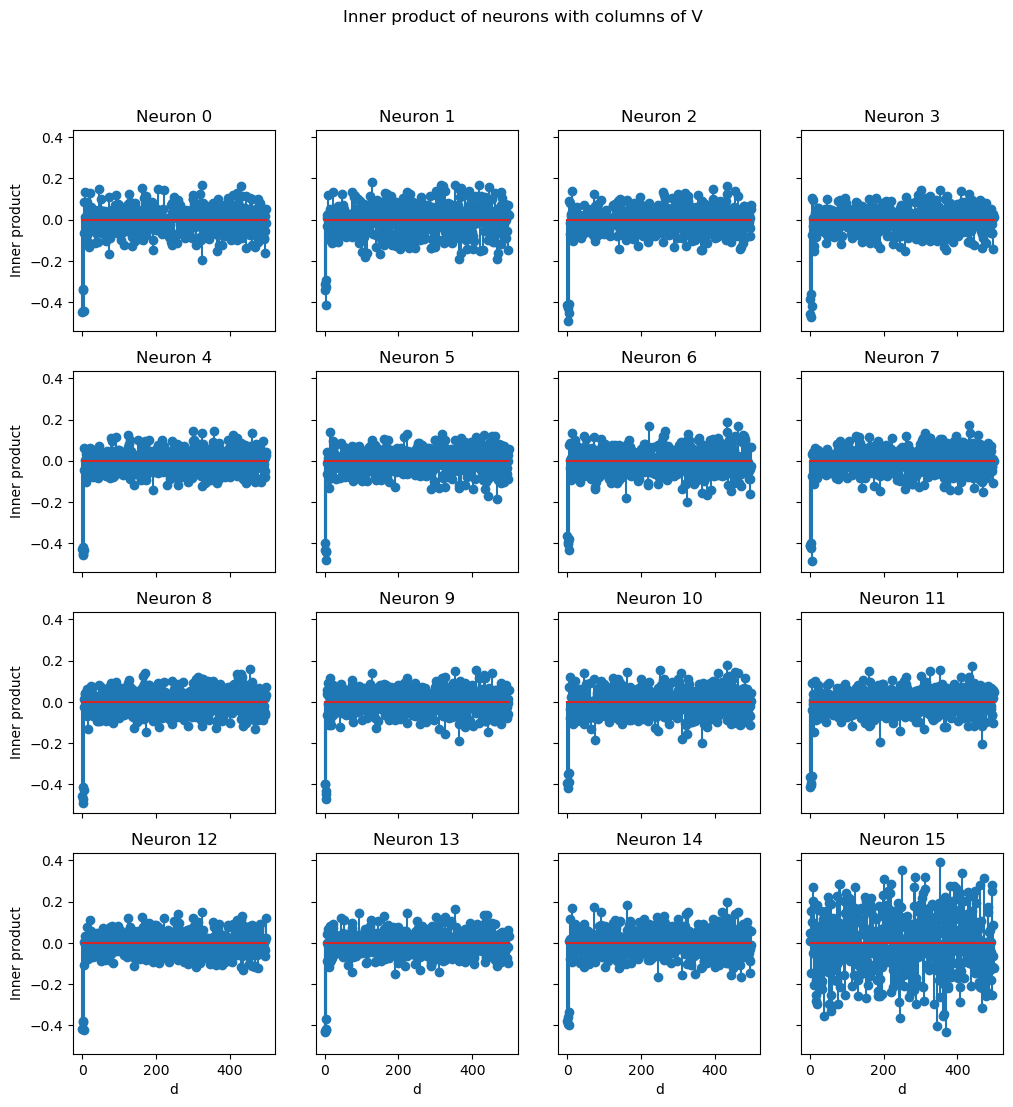

In [457]:
fig, axs = plt.subplots(4,4, figsize = (12,12), sharey = True, sharex = True)
for i in range(16):
    r = i//4
    c = i%4
    axs[r,c].stem(range(d), D[i,:])
    axs[r,c].set_title("Neuron " + str(i))
    if (r == 3):
        axs[r,c].set_xlabel("d")
    if (c == 0):
        axs[r,c].set_ylabel("Inner product")
#     axs[r,c].axhline(y = b[i], color = 'k', linestyle = '-')
fig.suptitle("Inner product of neurons with columns of V")

### Analysis of average activations of data types by group (false / true + positive / negative)

In [ ]:
# TODO

### Analysis of overlap between neurons

In [458]:
Wn = W.detach().numpy()

In [459]:
Gw = Wn@np.transpose(Wn)

In [460]:
Gw.shape

(100, 100)

<AxesSubplot:>

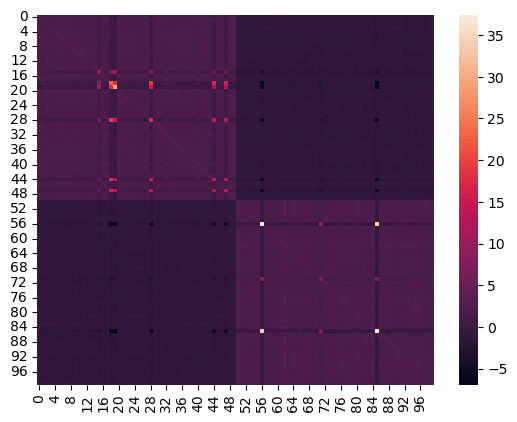

In [461]:
sns.heatmap(Gw)